# Lab-3

### Import packages

In [1]:
import pandas as pd
import category_encoders as ce
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.metrics import mean_absolute_error, confusion_matrix, roc_curve, roc_auc_score, classification_report, auc
from xgboost import XGBRFClassifier
import warnings
warnings.filterwarnings("ignore")

### Auxiliary Procedures

In [2]:
def display_multiclass_roc(clf, X_test, y_test, n_classes, title, figsize=(17, 6)):
    y_score = clf.predict_proba(X_test)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve for multiclass classification evaluation - ' + title)
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for class %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

In [3]:
def display_confusion_matrix(y_test, y_pred, title, labels, figsize=(8, 6)):
    cm = confusion_matrix(y_true = y_test, y_pred = y_pred)
    plt.figure(figsize = figsize)
    sns.heatmap(cm, annot = True, cmap='Greens', yticklabels = labels, xticklabels = labels, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix' + title)
    plt.show();

### Import data

In [4]:
df = pd.read_csv('resources/car_evaluation.csv')
df.columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


### Data preprocessing

In [5]:
encoder = ce.OrdinalEncoder(cols=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class'])
df = encoder.fit_transform(df)
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,1,1,1,1,1,1,1
1,1,1,1,1,1,2,1
2,1,1,1,1,2,3,1
3,1,1,1,1,2,1,1
4,1,1,1,1,2,2,1


In [6]:
X = df.drop('class', axis= 1)
y = df['class'] - 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Random Forest

In [7]:
rf = RandomForestClassifier(min_samples_split=7, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f'Random forest mean accuracy: {rf.score(X_test, y_test)}')
print(f'Random forest mean absolute error: {mean_absolute_error(y_test, y_pred)}')

Random forest mean accuracy: 0.9682080924855492
Random forest mean absolute error: 0.03757225433526012


In [8]:
plt.figure(figsize=(150, 75))
plot_tree(rf.estimators_[0], filled=True, feature_names=X.columns, rounded=True, proportion=True)
plt.savefig('random_forest_decision_tree.png')
plt.show()

<Axes: ylabel='cols'>

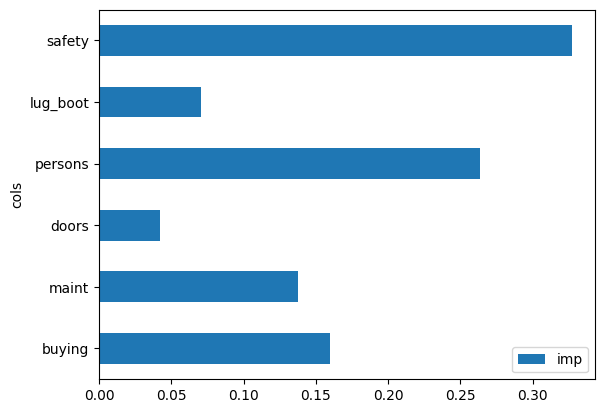

In [9]:
pd.DataFrame(dict(cols=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'], imp=rf.feature_importances_)).plot('cols', 'imp', 'barh')

In [10]:
print(classification_report(y_test, y_pred, target_names=['unacc', 'acc', 'good', 'vgood']))

              precision    recall  f1-score   support

       unacc       1.00      1.00      1.00       237
         acc       0.95      0.97      0.96        77
        good       0.72      0.76      0.74        17
       vgood       0.83      0.67      0.74        15

    accuracy                           0.97       346
   macro avg       0.88      0.85      0.86       346
weighted avg       0.97      0.97      0.97       346



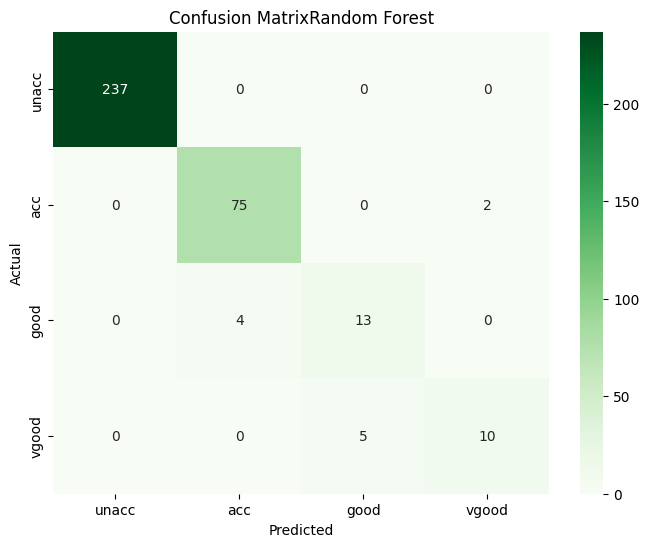

In [11]:
display_confusion_matrix(y_test, y_pred, "Random Forest", ['unacc', 'acc', 'good', 'vgood'], (8, 6))

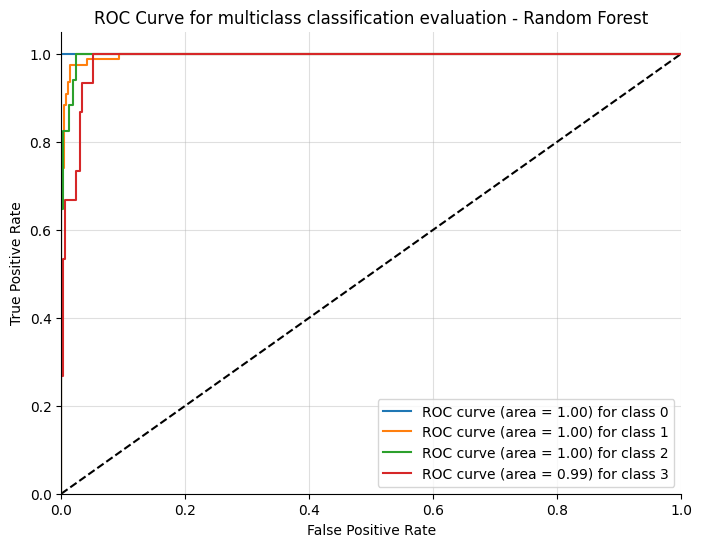

In [12]:
display_multiclass_roc(rf, X_test, y_test, 4, "Random Forest", (8, 6))

## XGBoost

In [13]:
xgb = XGBRFClassifier(random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(f'XGBoost mean accuracy: {xgb.score(X_test, y_test)}')
print(f'XGBoost mean absolute error: {mean_absolute_error(y_test, y_pred)}')

XGBoost mean accuracy: 0.9393063583815029
XGBoost mean absolute error: 0.07514450867052024


In [14]:
print(classification_report(y_test, y_pred, target_names=['unacc', 'acc', 'good', 'vgood']))

              precision    recall  f1-score   support

       unacc       1.00      0.98      0.99       237
         acc       0.87      0.95      0.91        77
        good       0.63      0.71      0.67        17
       vgood       0.70      0.47      0.56        15

    accuracy                           0.94       346
   macro avg       0.80      0.78      0.78       346
weighted avg       0.94      0.94      0.94       346



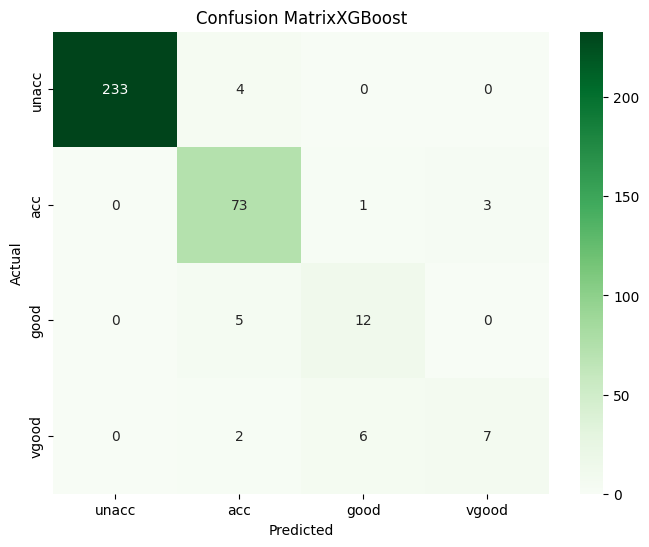

In [15]:
display_confusion_matrix(y_test, y_pred, "XGBoost", ['unacc', 'acc', 'good', 'vgood'], (8, 6))

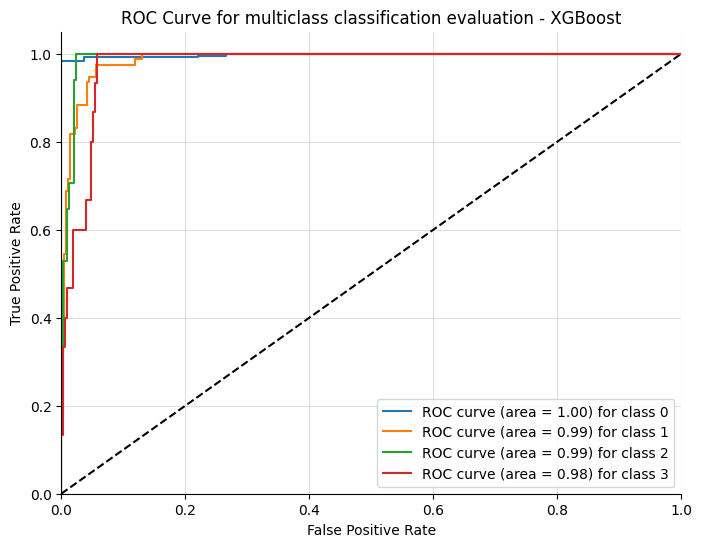

In [16]:
display_multiclass_roc(xgb, X_test, y_test, 4, "XGBoost", (8, 6))